## Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
!pip install pmdarima
from pmdarima import auto_arima
import sklearn.metrics as metrics
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from prophet import Prophet
import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential
import xgboost

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from plotly import tools 
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 45.0 MB/s eta 0:00:00


## Load datasets

In [2]:
# Load data
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
holiday = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
transac = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

## Merge datasets
This notebook only considers data of store 1.

In [3]:
#MERGE TO CHECK CORRELATION
# Merge train with transactions
store_id = 1
train = train[train['store_nbr']==store_id]
train_sum = train.groupby(['date','store_nbr','family'])['sales','onpromotion'].sum().reset_index() # To get each row represent to daily sales of a product category.
df_merge = train_sum.join( transac.set_index(keys = ['date','store_nbr']),
                            on = ['date','store_nbr'], 
                            how = 'left'
                            )
# Merge with oil
df_merge= df_merge.join(
                oil.set_index(keys='date'),
                on = 'date',
                how='left'
                )
# Merge with holiday
holi_df = holiday[(holiday['transferred']==False) | (holiday['type']!='Work Day')]
df_merge= df_merge.join(
                holi_df.set_index(keys='date'),
                on = 'date',
                how='left',
                rsuffix = '_h'
                )
#Drop unused columns and rename columns
df=df_merge.drop(['transferred','description','locale_name','store_nbr'],axis=1)
df.columns = ['Date','Family','Sales',
              'Onpromotion','Transactions','Oil',
              'Type_H','Locate_H']

df

,Date,Family,Sales,Onpromotion,Transactions,Oil,Type_H,Locate_H
0,2013-01-01,AUTOMOTIVE,0.000000,0,NaN,NaN,Holiday,National
1,2013-01-01,BABY CARE,0.000000,0,NaN,NaN,Holiday,National
2,2013-01-01,BEAUTY,0.000000,0,NaN,NaN,Holiday,National
3,2013-01-01,BEVERAGES,0.000000,0,NaN,NaN,Holiday,National
4,2013-01-01,BOOKS,0.000000,0,NaN,NaN,Holiday,National
...,...,...,...,...,...,...,...,...
55567,2017-08-15,POULTRY,234.892000,0,1693.0,47.57,Holiday,Local
55568,2017-08-15,PREPARED FOODS,42.822998,0,1693.0,47.57,Holiday,Local
55569,2017-08-15,PRODUCE,2240.230000,7,1693.0,47.57,Holiday,Local
55570,2017-08-15,SCHOOL AND OFFICE SUPPLIES,0.000000,0,1693.0,47.57,Holiday,Local


About features in the dataset:
* `Family` identifies the type of product sold.
* `Sales` gives the total sales units for a product family at a particular store on a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
* `Onpromotion` gives the total number of items in a product family that were being promoted at a store on a given date.
* Daily `Oil` price is included. Ecuador is an oil-dependent country, and its economic health is highly vulnerable to shocks in oil prices.
* `Type_H` is the type of holiday.
* `Locate_H` is the location of the holiday.
* `Transactions`: number of transactions in a day of the store.

## Process data
The next step is to get more useful features from `Date` feature, handle missing values and rename values of family features.

### Handle datetime feature

In [4]:
# Convert date into datetime type
df['Date'] = pd.to_datetime(df['Date'])
# From date get month, week day and day features
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday
df['Day'] = df['Date'].dt.day
# Add year-month column for visualisation purposes.
df['Y_M'] = df["Date"].dt.to_period('M')
df['Y_M'] = df["Y_M"].dt.to_timestamp()

df.head()

,Date,Family,Sales,Onpromotion,Transactions,Oil,Type_H,Locate_H,Month,Weekday,Day,Y_M
0,2013-01-01,AUTOMOTIVE,0.0,0,NaN,NaN,Holiday,National,1,1,1,2013-01-01
1,2013-01-01,BABY CARE,0.0,0,NaN,NaN,Holiday,National,1,1,1,2013-01-01
2,2013-01-01,BEAUTY,0.0,0,NaN,NaN,Holiday,National,1,1,1,2013-01-01
3,2013-01-01,BEVERAGES,0.0,0,NaN,NaN,Holiday,National,1,1,1,2013-01-01
4,2013-01-01,BOOKS,0.0,0,NaN,NaN,Holiday,National,1,1,1,2013-01-01


### Handle missing values

In [5]:
# Check NA values
print(df.isna().sum()/len(df))

Date            0.000000
Family          0.000000
Sales           0.000000
Onpromotion     0.000000
Transactions    0.004667
Oil             0.312719
Type_H          0.835473
Locate_H        0.835473
Month           0.000000
Weekday         0.000000
Day             0.000000
Y_M             0.000000
dtype: float64


The missing percentages of `Type_H`, `Locate_H` and `Oil` are high.
* Missing values in `Type_H` and `Locate_H` indicate a normal day without a holiday -> Replacing by `Normal` and `None`.
* Missing values in `Oil` -> Replacing by backward fill.
* Missing values in `Transactions` means no purchase was made -> Replacing by 0.

The family values re-format with title style.

In [6]:
# Fill NA values
df['Type_H']= df['Type_H'].fillna("Normal")
df['Locate_H'] = df['Locate_H'].fillna('None')
df['Transactions'] = df['Transactions'].fillna(0)
df['Oil']=df[['Oil']].interpolate(method='bfill')

# Format family values
df['Family']= [i.title().replace(' ','') for i in df['Family']]

df

,Date,Family,Sales,Onpromotion,Transactions,Oil,Type_H,Locate_H,Month,Weekday,Day,Y_M
0,2013-01-01,Automotive,0.000000,0,0.0,93.14,Holiday,National,1,1,1,2013-01-01
1,2013-01-01,BabyCare,0.000000,0,0.0,93.14,Holiday,National,1,1,1,2013-01-01
2,2013-01-01,Beauty,0.000000,0,0.0,93.14,Holiday,National,1,1,1,2013-01-01
3,2013-01-01,Beverages,0.000000,0,0.0,93.14,Holiday,National,1,1,1,2013-01-01
4,2013-01-01,Books,0.000000,0,0.0,93.14,Holiday,National,1,1,1,2013-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...
55567,2017-08-15,Poultry,234.892000,0,1693.0,47.57,Holiday,Local,8,1,15,2017-08-01
55568,2017-08-15,PreparedFoods,42.822998,0,1693.0,47.57,Holiday,Local,8,1,15,2017-08-01
55569,2017-08-15,Produce,2240.230000,7,1693.0,47.57,Holiday,Local,8,1,15,2017-08-01
55570,2017-08-15,SchoolAndOfficeSupplies,0.000000,0,1693.0,47.57,Holiday,Local,8,1,15,2017-08-01


## Explore data

### Overall

<AxesSubplot:title={'center':'Total sales by family'}, ylabel='Family'>

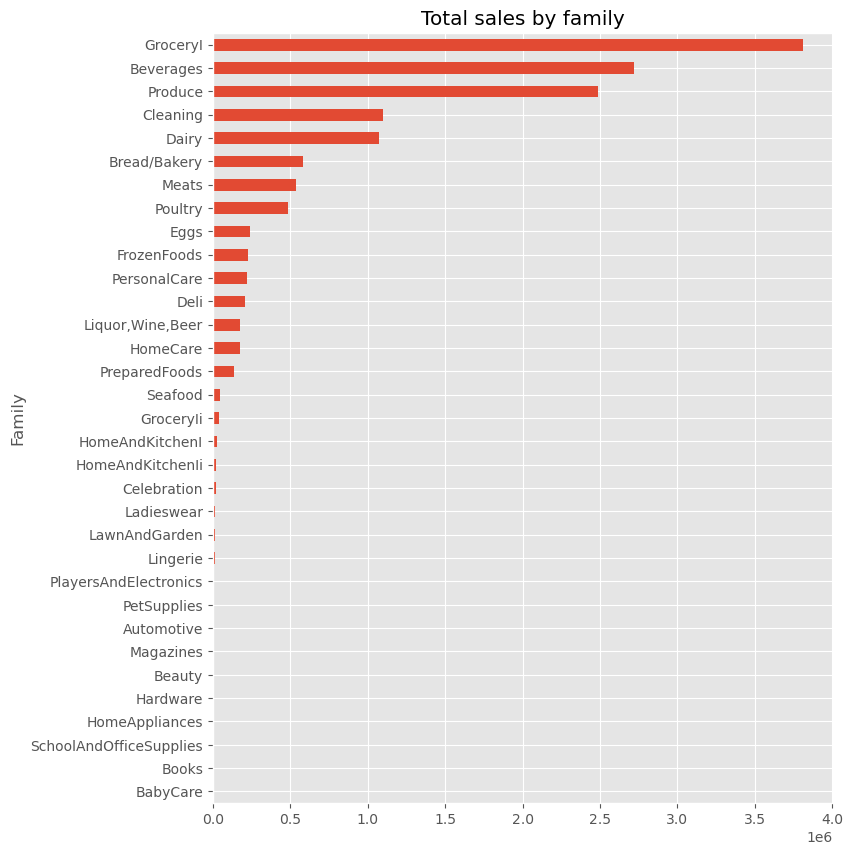

In [7]:
# Get total sales by family plot
df.groupby('Family')['Sales'].sum().sort_values(ascending = True).plot.barh(figsize=(8,10),
                                                                           title = 'Total sales by family')

Regarding sales, food and drink products have high sales in the stores. Next are some items for cleaning, home care and personal care.

In [8]:
# Get numerical features and put it in same scale.
df_time = df.groupby(['Y_M'])['Sales','Onpromotion','Transactions','Oil'].mean().reset_index()
df_time_scaled = MinMaxScaler().fit_transform(df_time[['Sales','Onpromotion','Transactions','Oil']])
df_time = pd.concat([df_time['Y_M'],pd.DataFrame(df_time_scaled)],axis = 1)
df_time.columns = ['Y_M','Sales','Onpromotion','Transactions','Oil']
df_time = df_time.set_index('Y_M')

# Plot interactive line chart.
fig = go.Figure()
for column,v in zip(df_time.columns.to_list(),[True, False, False, False]):
    fig.add_trace(
        go.Line(
            x = df_time.index,
            y = df_time[column],
            name = column,
            visible = v
        )
    )
fig.update_layout(
    updatemenus=[go.layout.Updatemenu(
        active=0,
        buttons=list(
            [dict(label = 'Sales',
                  method = 'update',
                  args = [{'visible': [True, False, False, False]},
                          {'title': 'Average daily sales of 1 product line compared to average daily transactions,number of promoted products oil price by month and year',
                           'showlegend':True}]),
             dict(label = 'Sales vs Onpromotion',
                  method = 'update',
                  args = [{'visible': [True, True, False, False]}, # the index of True aligns with the indices of plot traces
                          {'title': 'Average daily sales of 1 product line compared to average daily number of promoted products by month and year',
                           'showlegend':True}]),
             dict(label = 'Sales vs Transactions',
                  method = 'update',
                  args = [{'visible': [True, False, True, False]},
                          {'title': 'Average daily sales of 1 product lines compared to average daily transactions by month and year',
                           'showlegend':True}]),
             dict(label = 'Sales vs Oil',
                  method = 'update',
                  args = [{'visible': [True, False, False, True]},
                          {'title': 'Average daily sales of 1 product lines compared to average daily oil price by month and year',
                           'showlegend':True}]),
            ])
        )
    ])

fig.show()

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




* `Sales` vs `Onpromotion`: More than one year in business, the store started to run promotions, positively impacting daily sales. Since then, the store has tried to increase the number of promoted items. However, from the end of 2016, the effect of promotion was not strong as at the beginning. It may indicate the time for focusing on qualify of promotions rather than quantity or the post-effect of the severe earthquake in Apr 2016. It needs more information to define the real reason before making business decisions.
* `Sales` vs `Transactions` & `Oil` prices: Initially, consumers only bought a little during shopping time. Until Jan 2014, they tended to buy more. It can be explained by the store has built trust. Since Jan 2015, when oil prices had a significant drop, consumers felt more comfortable spending more on shopping.
* `Sales` vs `Oil` prices: It was clear that the oil price and the sales had an inverse relationship. Oil prices went high, making consumers spend more on oil and could affect the prices of items; hence, the sales went down and vice versa.

In [9]:
# Time series chart for all product types
# Aggregate data for the chart
df_i = df.groupby(['Y_M','Family'])['Sales'].mean().unstack()
df_i['All'] = df_i.mean(axis =1)
cols = [list(df_i.columns)[-1]] + list(df_i.columns)[:-1]
df_i = df_i[cols]
df_i = df_i.reset_index()

# Create the chart with plotly
fig = px.line(df_i, 
             x='Y_M', 
             y="All",
             title = 'Average daily sales of all items'
             )
fig.update_traces(hovertemplate='<b>Date = %{x}<br>Sales = %{y}')
fig.update_layout(
        xaxis_title="Date", 
        updatemenus=[
            {
                "buttons": [ # Dropdown buttons
                    {
                        "label": c,
                        "method": "update",
                        "args": [
                                {axis: [df_i[c]]},
                                {'title': ('Average daily %s sales' % c.lower()), f"{axis}axis": {"title": {"text": c.replace('_',' ')+ ' sales'}}},
                                {'visible': True},
                                ],
                    }
                    for c in list(df_i.drop('Y_M',axis=1).columns)
                ],
            }
            for axis in "xy"
        ]
    )

# Show the chart
fig.show()

From this chart, it is easy to investigate more aspects of sales of product types:
When the product started to sell, the trends, seasonal sales and how many units were sold for each family. From that, it gave an overall view of the business health of the store.

Overall, there are some quick notes for the sales of the store.
Patterns can be divided into 4 types:
* Group 1: Increased high -> keeping stable and stop growing: Automotive, Celebration, Dairy, Home and Kitchen I and II, Home care, Personal care, Ladies wear, Pet supplies, Produce, Beverages...
* Group 2: Increasing: Beauty products, Grocery I
* Group 3: Increased high -> stayed stable -> decreasing: Deli, Eggs, Lingerie, Meats, Prepared Food and Poultry.
* Group 4: No significant trend: Hardware, Home appliances, Cleaning, Grocery II, Seafood.

Many products spiked in Jan, Mar, Jul, Sep and Dec 2014. Some products have clear seasonality, like Grocery I and II, Frozen Food, and Liquor.
Most food products stop growing or have a decreasing trend, which needs collecting more data to find the reason.

Moreover, 2 below charts can give more insights in term of month, week day, days of month and holiday features.


In [10]:
# Innitial the figure
fig = tools.make_subplots(rows=1, 
                          cols=3,
                          shared_yaxes=True,
                          horizontal_spacing=0.02
                         )

# Add traces into the figure
for i,v  in {'Month':(1,1),'Weekday':(1,2),'Day':(1,3)}.items():
    # Aggregate data for the trace
    df_i = df.groupby([i,'Family'])['Sales'].mean().unstack()
    df_i['All'] = df_i.mean(axis =1)
    cols = [list(df_i.columns)[-1]] + list(df_i.columns)[:-1]
    df_i = df_i[cols]
    df_i = df_i.reset_index()
    # Create the trace
    trace = go.Line(
                x = df_i[i],
                y = df_i["All"],
                name = i,
                hovertemplate= i+' = %{x}<br>Sales = %{y}',
                text = df_i["All"]
                )
    # Append the trace into the figure and adjust subplot parameters
    fig.append_trace(trace,v[0],v[1])
    fig.update_xaxes(title_text= i , row=v[0], col=v[1],dtick=1)

# Update common parameters for the figures
fig.update_yaxes(title_text= 'All items', row = 1, col = 1)
fig.update_layout(
        title = 'Average daily sales by month, weekday and days of month',
        showlegend=False,
        updatemenus=[ # Dropdown buttons
            {
                "buttons": [
                    {
                        "label": c,
                        "method": "update",
                        "args": [
                                {axis: [df_i[c]]},
                                {f"{axis}axis": {"title": {"text": c+' sales'}}},
                                ],
                    }
                    for c in list(df_i.drop(i,axis=1).columns)
                ],
            }
            for axis in "xy"
        ]
    )
# Show the figure
fig.show()

In [11]:
#Innitial the figure
fig = tools.make_subplots(rows=1, 
                          cols=2,
                          shared_yaxes=True,
                          horizontal_spacing=0.02
                         )

# Add traces into the figure
for i,v  in {'Type_H':(1,1),'Locate_H':(1,2)}.items():
    # Aggregate data for the trace
    df_i = df.groupby([i,'Family'])['Sales'].mean().unstack()
    df_i['All'] = df_i.mean(axis =1)
    cols = [list(df_i.columns)[-1]] + list(df_i.columns)[:-1]
    df_i = df_i[cols]
    df_i = df_i.reset_index()
    # Create the trace
    trace = go.Bar(
                x = df_i[i],
                y = df_i["All"],
                name = i,
                #hovertemplate= i+' = %{x}<br>Sales = %{y}',
                texttemplate= '%{y:.2f}',
                textposition = 'inside'
                )
    # Append the trace into the figure and adjust subplot parameters
    fig.append_trace(trace,v[0],v[1])
    fig.update_xaxes(title_text= 'Holiday '+ i.split('_')[0] ,
                     row=v[0], 
                     col=v[1],
                     dtick=1)

# Update common parameters for the figures
fig.update_yaxes(title_text= 'All items', 
                 row = 1, 
                 col = 1)
fig.update_layout(
        title = 'Average daily sales by holiday type and location',
        hovermode=False,
        showlegend=False,
        updatemenus=[
            {
                "buttons": [ # Dropdown buttons
                    {
                        "label": c,
                        "method": "update",
                        "args": [
                                {axis: [df_i[c]]},
                                {f"{axis}axis": {"title": {"text": c+' sales'}}},
                                ],
                    }
                    for c in list(df_i.drop(i,axis=1).columns)
                ],
            }
            for axis in "xy"
        ]
    )

#Show the figure
fig.show()

About different types of events:
* `Event` and `Holiday`
* `Transfer` is like a typical day than a holiday because the holiday was moved to another day.
* `Bridge`are extra days that are added to a holiday.
* `Work day`, which is a day not normally scheduled for work (e.g., Saturday) that is meant to pay back the `Bridge`.
* `Additional` holidays are days added to a regular calendar holiday.
* `Normal` is a normal day.

### Detail
This part is to get further insights into 1 type of product which want to analyse and the correlation with other features:
* Transform data (The data also is used to train models later)
* Explore detailed data:
 * Choose the product family want to predict. 
 * Check the time series of sales of the family.
 * Run a model to find important exogenous features of the product family.
 * Visual importance score to understand the relationships and extract some interesting insights

#### Transform data

* The idea is to transfer family-related features into multiple features based on `family`. It included `sales` and `onpromotion`. 
* Moreover, categorical features also are converted into dummies.
* Make sure all sets have the same number of rows, then concat it for the final data.
* Scale the final data

In [12]:
s=df.drop('Y_M',axis=1)
# Convert sales
t1 = s[['Date','Family','Sales']]
t1= t1.groupby(['Date','Family'])['Sales'].sum().unstack().reset_index()
t1.columns = [i+"_sales" if i != 'Date' else i for i in t1.columns]

#Convert onpromotion
t2 = s[['Date','Family','Onpromotion']]
t2= t2.groupby(['Date','Family'])['Onpromotion'].sum().unstack().reset_index()
t2.columns = [i+"_promo" if i != 'Date' else i for i in t2.columns]

#Convert type_h and locate_h
t3 = s.drop(['Family','Sales','Onpromotion'],axis =1).drop_duplicates()
t3=pd.get_dummies(t3[['Date','Type_H','Locate_H']])
t3 = t3.groupby('Date').max().reset_index()

# Keep others and remove duplicates
t4 = s.drop(['Family','Sales','Onpromotion','Type_H','Locate_H'],axis =1).drop_duplicates()

# Concat 4 dataframes above into 1
t = pd.concat([t1.set_index('Date'),
               t2.set_index('Date'),
               t3.set_index('Date'),
               t4.set_index('Date')], join='outer', axis=1).reset_index()

#Get features only contain 0
zero_id = [i+1 for i in np.where(t.sum()==0)[0]]
t.iloc[:,zero_id]
#Drop zero features
t=t.drop(t.iloc[:,zero_id].columns,axis=1)

t

,Date,Automotive_sales,Beauty_sales,Beverages_sales,Books_sales,Bread/Bakery_sales,Celebration_sales,Cleaning_sales,Dairy_sales,Deli_sales,...,Type_H_Work Day,Locate_H_Local,Locate_H_National,Locate_H_None,Locate_H_Regional,Transactions,Oil,Month,Weekday,Day
0,2013-01-01,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000,...,0,0,1,0,0,0.0,93.14,1,1,1
1,2013-01-02,2.0,2.0,1091.0,0.0,470.65200,0.0,1060.0,579.0,164.069,...,0,0,0,1,0,2111.0,93.14,1,2,2
2,2013-01-03,3.0,0.0,919.0,0.0,310.65500,0.0,836.0,453.0,151.582,...,0,0,0,1,0,1833.0,92.97,1,3,3
3,2013-01-04,3.0,3.0,953.0,0.0,198.36600,0.0,827.0,460.0,131.411,...,0,0,0,1,0,1863.0,93.12,1,4,4
4,2013-01-05,5.0,3.0,1160.0,0.0,301.05700,0.0,811.0,464.0,118.613,...,1,0,1,0,0,1509.0,93.20,1,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,2017-08-11,1.0,1.0,1006.0,0.0,145.60700,4.0,341.0,343.0,64.302,...,0,0,1,0,0,570.0,48.81,8,4,11
1680,2017-08-12,6.0,3.0,1659.0,0.0,243.22000,3.0,351.0,526.0,99.488,...,0,0,0,1,0,1004.0,47.59,8,5,12
1681,2017-08-13,1.0,1.0,803.0,0.0,136.67900,1.0,169.0,266.0,47.770,...,0,0,0,1,0,416.0,47.59,8,6,13
1682,2017-08-14,1.0,6.0,2201.0,0.0,346.03800,4.0,571.0,699.0,154.578,...,0,0,0,1,0,1733.0,47.59,8,0,14


In [13]:
#Scaled data
scaler = MinMaxScaler()
t_scaled= pd.DataFrame(scaler.fit_transform(t.set_index('Date')), 
                        columns = t.set_index('Date').columns,
                        index= t['Date'])

t_scaled['Y_M'] = t_scaled.index.to_period('M').to_timestamp() # For visualisation later_scaled 

t_scaled

,Automotive_sales,Beauty_sales,Beverages_sales,Books_sales,Bread/Bakery_sales,Celebration_sales,Cleaning_sales,Dairy_sales,Deli_sales,Eggs_sales,...,Locate_H_Local,Locate_H_National,Locate_H_None,Locate_H_Regional,Transactions,Oil,Month,Weekday,Day,Y_M
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.000000,0.792965,0.000000,0.166667,0.000000,2013-01-01
2013-01-02,0.10,0.095238,0.176537,0.0,0.360155,0.000000,0.369081,0.2316,0.274432,0.480469,...,0.0,0.0,1.0,0.0,0.698313,0.792965,0.000000,0.333333,0.033333,2013-01-01
2013-01-03,0.15,0.000000,0.148706,0.0,0.237721,0.000000,0.291086,0.1812,0.253546,0.396484,...,0.0,0.0,1.0,0.0,0.606351,0.790951,0.000000,0.500000,0.066667,2013-01-01
2013-01-04,0.15,0.142857,0.154207,0.0,0.151795,0.000000,0.287953,0.1840,0.219806,0.333984,...,0.0,0.0,1.0,0.0,0.616275,0.792728,0.000000,0.666667,0.100000,2013-01-01
2013-01-05,0.25,0.142857,0.187702,0.0,0.230377,0.000000,0.282382,0.1856,0.198400,0.345703,...,0.0,1.0,0.0,0.0,0.499173,0.793675,0.000000,0.833333,0.133333,2013-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,0.05,0.047619,0.162783,0.0,0.111422,0.003063,0.118733,0.1372,0.107556,0.167969,...,0.0,1.0,0.0,0.0,0.188554,0.267914,0.636364,0.666667,0.333333,2017-08-01
2017-08-12,0.30,0.142857,0.268447,0.0,0.186118,0.002297,0.122214,0.2104,0.166410,0.220703,...,0.0,0.0,1.0,0.0,0.332120,0.253464,0.636364,0.833333,0.366667,2017-08-01
2017-08-13,0.05,0.047619,0.129935,0.0,0.104590,0.000766,0.058844,0.1064,0.079903,0.117188,...,0.0,0.0,1.0,0.0,0.137612,0.253464,0.636364,1.000000,0.400000,2017-08-01


#### Explore detailed data

In [14]:
# Check stationary of time series y
def check_y(y,y_name):
    '''
    Get visualisations of the target series, including
    time series plots, ACF and PACF 
    '''
    #Get time series plots
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(20, 5))
    t_scaled.groupby('Y_M')[y].mean().plot(title = 'Mean monthly %s' % y_name,ax = ax1)
    plot_acf(t_scaled[y], ax=ax2)
    plot_pacf(t_scaled[y], ax=ax3)
    plt.show()
    return None

def split_df (y,r = 0.9):
    '''
    After choosing y, get names of exogenous features and split data into train and test.
    Return exog name, train and test data frame
    '''
    # Get exog features names
    exo = list(t_scaled.columns)
    exo = [i for i in exo if i not in [y,'Y_M','Date']]
    #Split data
    df_train = t_scaled[:int(r*(len(t_scaled)))].reset_index()
    df_test= t_scaled[int(r*(len(t_scaled))):].reset_index()
    return exo, df_train, df_test

def check_important_x(y,exo,y_name,df_train,df_test):
    '''
    Get importance scores of exogenous features based on an XGBRegessor model
    and visualisations. 
    Return a score dataframe
    '''
    # XGB Regression
    xg_m = xgboost.XGBRegressor()
    xg_m.fit(df_train[exo],df_train[y])

    # Get scores and plot it
    score = pd.concat([pd.Series(exo),pd.Series(xg_m.feature_importances_)],axis=1)
    score.columns = ['f','s']
    if (score['s'].sum() == 0):
        print('No important exogenous variables were found to predict %s' % y.lower())
        return None
    else: 
        score = score.sort_values('s',ascending = False).reset_index(drop=True)
        score[:15][score['s']>0].plot.bar(y='s',
                                            x='f',
                                            legend = False,
                                            xlabel = 'Feature',
                                            ylabel = 'Importance score',
                                            title = 'Top 15 significant features for %s predictions' % y_name,
                                            figsize=(20, 5))
        plt.xticks(rotation=45)
        plt.show()
        # Plot between y and 6 important exogenous variables.
        top_exo = list(score[:6]['f'])

        fig, axes = plt.subplots(ncols=3,nrows=2,figsize=(20, 8))
        for x,ax in zip(top_exo,axes.flatten()):
            x_name = x.replace('_',' ')
            sns.regplot(y=df_train[y], 
                        x=df_train[x],
                        ax=ax)
            ax.set_xlabel(x_name)
            ax.set_ylabel(y_name)
        fig.suptitle('Scatter plots showing correlation between %s and top 6 exogenous variables' % (y_name),
                    fontsize = 15)
        plt.show()
        return score


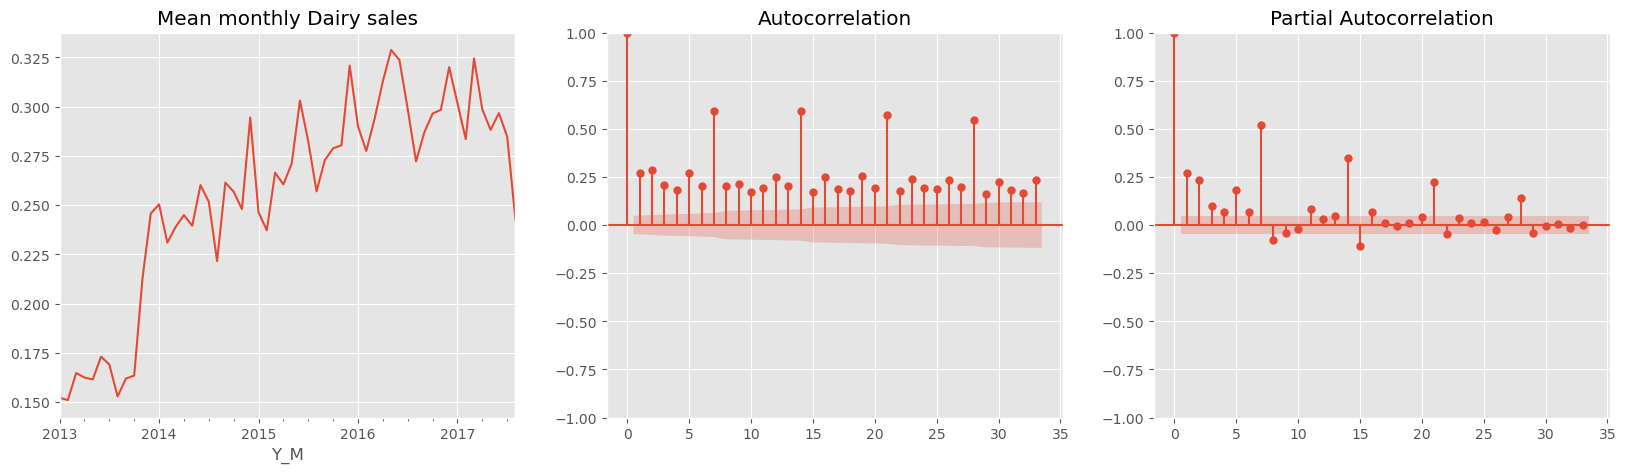

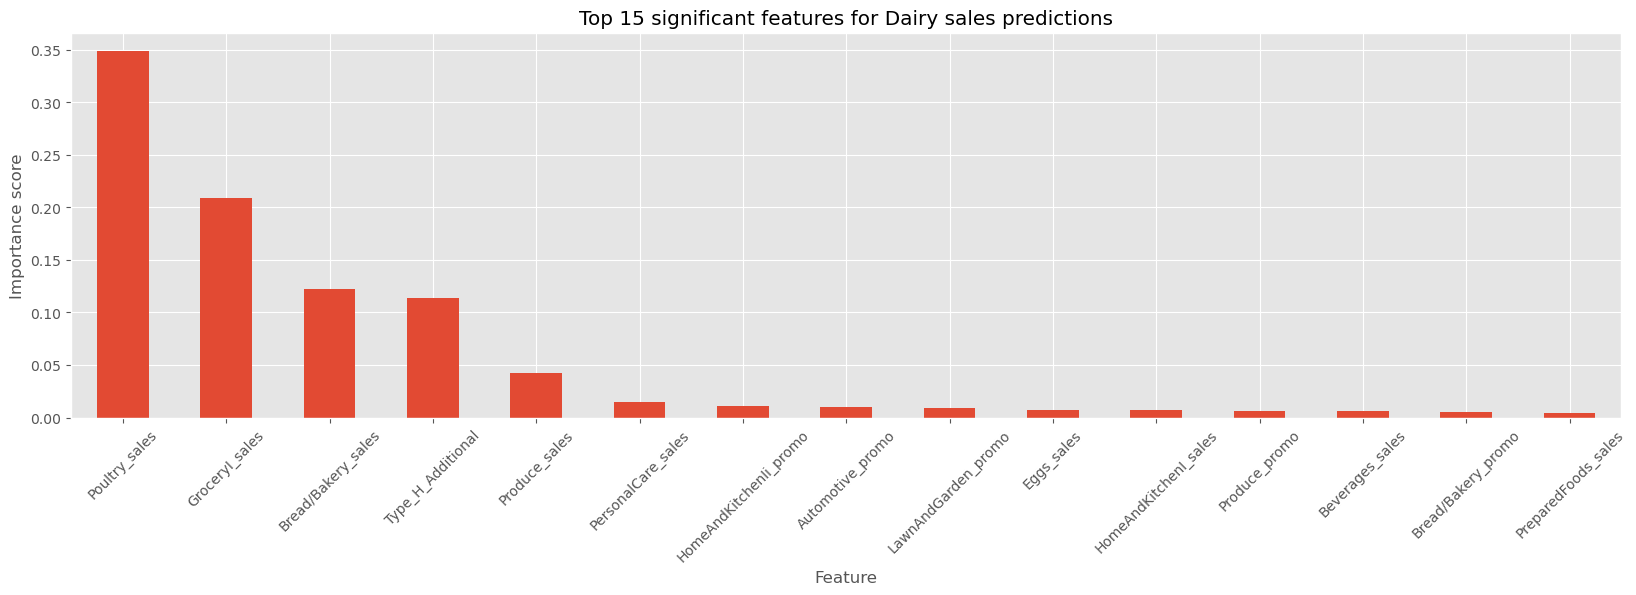

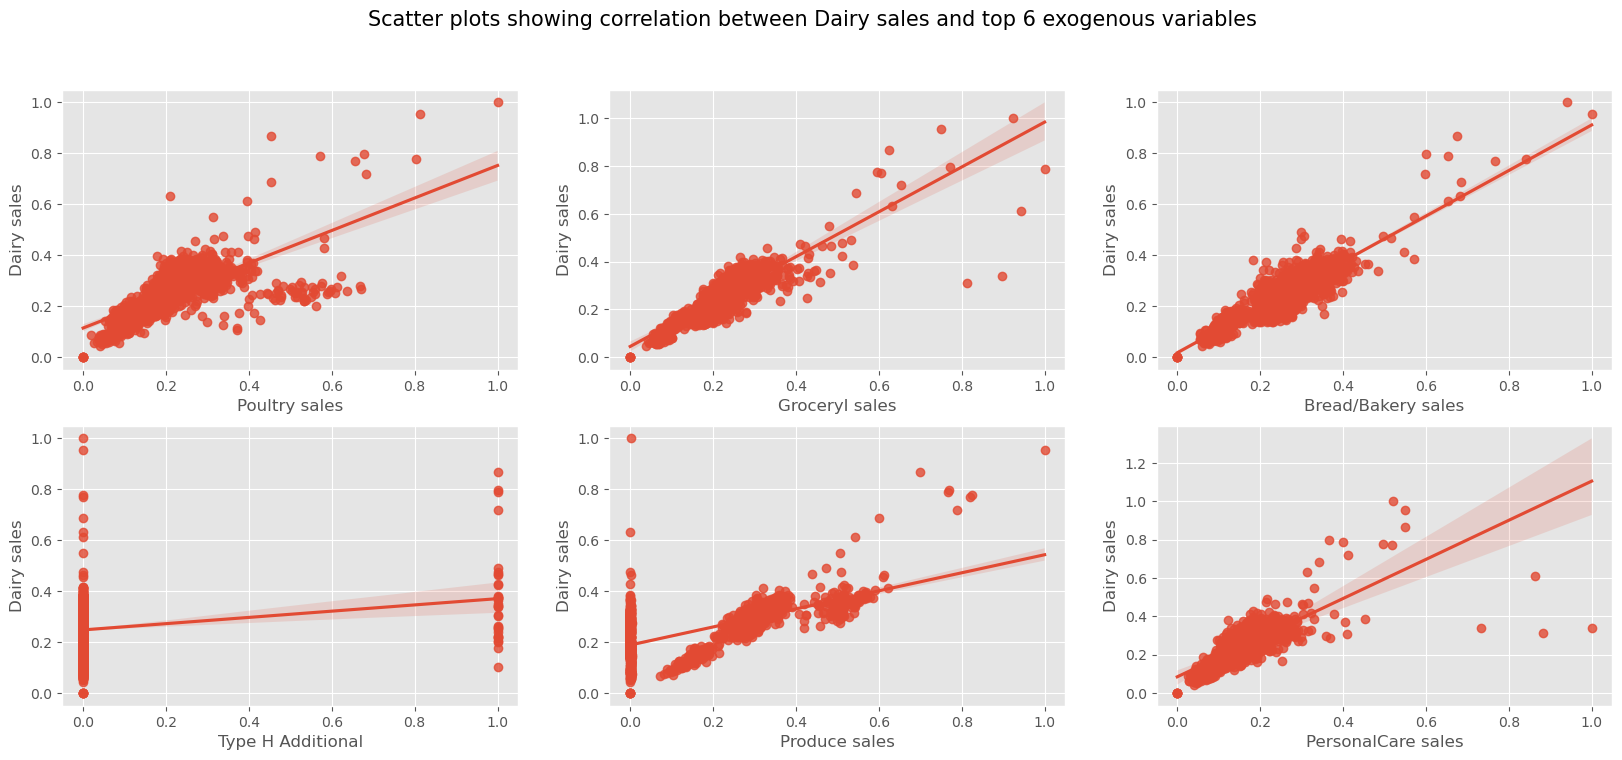

In [15]:
#Check y
y = 'Dairy_sales'
y_name = y.replace('_',' '.title())
check_y(y,y_name)

#Check importance scores of exogenous features 
exo,df_train,df_test = split_df(y)
score = check_important_x(y,
                          exo,
                          y_name,
                          df_train,
                          df_test)

* There is an increased trend and seasonal with a period of 6 months in the time series. Therefore, in the `auto.arima` model for this family, it is vital to use parameters `d = 1` and `m = 6` to make the series stationary. Moreover, ACF and PACF decrease significantly after lag 0.
* Top 15 significant features chart: Dairy sales are affected by 3 kinds of features: food sales and promotions (Poultry, GroceryI, Bread/Bakery, Eggs), home and care promoted products (home and kitchen, lawn & garden) and additional holiday. 
* Scatter plots: All item sales and promoted items positively correlate with dairy sales. It means consumers tend to buy dairy with different food products. Moreover, they also tend to buy dairy when the store has promotions for more food, home&kitchen, lawn&garden, and automotive items. It could be explained that after getting products with good prices, they have some extra money for other products. Consumers also buy more dairy items in additional holidays.

Change `y` to explore other product sales.

## Model data
The idea is to build each model for each family type to predict the sales of the type.
There are 4 types of testing models:
`XGBRegressor`,`auto.arima`,`Prophet` and `lstm` (long-short term memories).

In [16]:
#Defined function
def plot_predictions(forecast,m_type,y_name,ax):
    '''
    Return a plot to compare predicted and actual value
    '''
    f = pd.concat([df_test['Y_M'].reset_index(drop=True),forecast.reset_index(drop=True)],axis =1)
    f.columns = ['Y_M',y]
    f=f.groupby('Y_M')[y].mean().reset_index()

    train =df_train.groupby('Y_M')[y].mean().reset_index()
    test =df_test.groupby('Y_M')[y].mean().reset_index()

    test = test.set_index(pd.Index(range(len(train),len(test)+len(train))))
    f = f.set_index(pd.Index(range(len(train),len(test)+len(train))))

    ax.plot(train[y], label='Train')
    ax.plot(test[y], label='Actual') 
    ax.plot(f[y], label='Predicted') 
    ax.set_title(m_type + " "+y_name+' predictions')
    #plt.show()
    return None

#Evaluate model
def evaluate(y,yhat):
    '''
    Print out evalue metrics based on actual and predicted values
    '''
    mae = metrics.mean_absolute_error(y,yhat)
    mse = metrics.mean_squared_error(y,yhat)
    rmse = np.sqrt(mse) # or mse**(0.5)  
    r2 = metrics.r2_score(y,yhat)
    print(" MAE: %s \n MSE: %s \n RMSE: %s \n R-Squared: %s" % (mae,mse,rmse,r2))
    return None


# Get model lstm
def get_lstm_model(params, input_shape):
    '''
    Input param and input shape to get equivalent lstm model
    '''
    model = Sequential()
    model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(input_shape, 1)))
    model.add(Dropout(rate=params["dropout"]))
    
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(Dropout(rate=params["dropout"]))
    
    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(Dropout(rate=params["dropout"]))

    model.add(LSTM(units=params["lstm_units"], return_sequences=False))
    model.add(Dropout(rate=params["dropout"]))

    model.add(Dense(1))

    model.compile(loss=params["loss"],
              	optimizer=params["optimizer"],
              	metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

In this work, only top 15 significant features are used for training models.

In [17]:
# Keep only feature has importance score > 0
#exo = list(score['f'][score['s']>0])
exo = list(score['f'][:15])
print (exo)
print(' ')
print('Train size: %s \nTest size: %s' % (df_train[[y]+exo].shape,df_test[[y]+exo].shape))
print(' ')

['Poultry_sales', 'GroceryI_sales', 'Bread/Bakery_sales', 'Type_H_Additional', 'Produce_sales', 'PersonalCare_sales', 'HomeAndKitchenIi_promo', 'Automotive_promo', 'LawnAndGarden_promo', 'Eggs_sales', 'HomeAndKitchenI_sales', 'Produce_promo', 'Beverages_sales', 'Bread/Bakery_promo', 'PreparedFoods_sales']
 
Train size: (1515, 16) 
Test size: (169, 16)
 


In [18]:
#ARIMA model
arima_m = auto_arima(
                    df_train[y],
                    X=df_train[exo],
                    trace=True,
                    error_action="ignore",
                    suppress_warnings=True,
                    d=1,
                    m=6,
                    seasonal = True)

#Get predictions
arima_pred = arima_m.predict(n_periods=len(df_test),
                         X=df_test[exo]
                         )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=-7016.515, Time=15.32 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=-6373.809, Time=1.89 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=-6716.220, Time=9.02 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=-6980.353, Time=10.89 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=-6375.809, Time=2.50 sec
 ARIMA(2,1,2)(0,0,1)[6] intercept   : AIC=-7000.660, Time=14.65 sec
 ARIMA(2,1,2)(1,0,0)[6] intercept   : AIC=-7003.864, Time=13.28 sec
 ARIMA(2,1,2)(2,0,1)[6] intercept   : AIC=-7000.772, Time=20.68 sec
 ARIMA(2,1,2)(1,0,2)[6] intercept   : AIC=-7008.316, Time=18.71 sec
 ARIMA(2,1,2)(0,0,0)[6] intercept   : AIC=-7009.365, Time=8.62 sec
 ARIMA(2,1,2)(0,0,2)[6] intercept   : AIC=-7007.539, Time=18.36 sec
 ARIMA(2,1,2)(2,0,0)[6] intercept   : AIC=-7015.328, Time=20.51 sec
 ARIMA(2,1,2)(2,0,2)[6] intercept   : AIC=-7012.402, Time=19.86 sec
 ARIMA(1,1,2)(1,0,1)[6] intercept   : AIC=-7028.104, Time=14.33 sec
 ARIMA(1,

In [19]:
#PROPHET model
prophet_m = Prophet()
for feature in exo:
    prophet_m.add_regressor(feature)
    
prophet_m.fit(df_train[["Date", y] + exo].rename(columns={"Date": "ds", y: "y"}))

#Get predictions
prophet_pred = prophet_m.predict(df_test[["Date", y] + exo].rename(columns={"Date": "ds"}))['yhat']

09:47:32 - cmdstanpy - INFO - Chain [1] start processing
09:47:32 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
#LSTM model
params = {
        "loss": "mean_squared_error",
        "optimizer": "adam",
        "dropout": 0.1,
        "lstm_units": 90,
        "epochs": 100,
        "batch_size": 8,
        "es_patience" : 10
    } #parameters to get the model through the defined function.

lstm_m = get_lstm_model(params=params, 
                  input_shape=df_train[exo].shape[1]) #get model

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                               mode='min',
                                               patience=params["es_patience"]) # add early stopping.

#Split train data into 80% train and 20% validation.
lstm_train = df_train[:int(0.80*(len(df_train)))]
lstm_val = df_train[int(0.80*(len(df_train))):]
lstm_test = df_test

lstm_m.fit(
        lstm_train[exo],
        lstm_train[y],
        validation_data=(lstm_val[exo], lstm_val[y]),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        verbose=1,
        callbacks=[es_callback]
    )

#Get predictions
lstm_pred = pd.Series(lstm_m.predict(lstm_test[exo]).flatten())

Epoch 1/100
152/152 [==============================] - 14s 21ms/step - loss: 0.0044 - root_mean_squared_error: 0.0664 - mean_absolute_error: 0.0485 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.0318
Epoch 2/100
152/152 [==============================] - 2s 11ms/step - loss: 0.0025 - root_mean_squared_error: 0.0497 - mean_absolute_error: 0.0363 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0734 - val_mean_absolute_error: 0.0613
Epoch 3/100
152/152 [==============================] - 2s 10ms/step - loss: 0.0023 - root_mean_squared_error: 0.0481 - mean_absolute_error: 0.0349 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0570 - val_mean_absolute_error: 0.0399
Epoch 4/100
152/152 [==============================] - 2s 10ms/step - loss: 0.0021 - root_mean_squared_error: 0.0462 - mean_absolute_error: 0.0336 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.0300
Epoch 5/100
152/152 [==========================

In [21]:
# XGB Regression
xg_m = xgboost.XGBRegressor()
xg_m.fit(df_train[exo],df_train[y])
#Get predictions for xg model
xg_pred = pd.Series(xg_m.predict(df_test[exo]))

In [22]:
#Evaluation 
print('ARIMA model metrics:')
evaluate(df_test[y],arima_pred)
print(' ')
print('PROPHET model metrics:')
evaluate(df_test[y],prophet_pred)
print(' ')
print('LSTM model metrics:')
evaluate(df_test[y],lstm_pred)
print(' ')
print('XGB model metrics:')
evaluate(df_test[y],xg_pred)

ARIMA model metrics:
 MAE: 0.022248568547422597 
 MSE: 0.0008637215856614659 
 RMSE: 0.02938914060773921 
 R-Squared: 0.8690543601735798
 
PROPHET model metrics:
 MAE: 0.01967616149879431 
 MSE: 0.0007171949082991883 
 RMSE: 0.026780494922595967 
 R-Squared: 0.8912687285966508
 
LSTM model metrics:
 MAE: 0.02935338527965828 
 MSE: 0.0015554842534427225 
 RMSE: 0.039439627957711804 
 R-Squared: 0.7641787768323619
 
XGB model metrics:
 MAE: 0.02372151313864973 
 MSE: 0.0009681149886984619 
 RMSE: 0.031114546255705897 
 R-Squared: 0.853227661870251


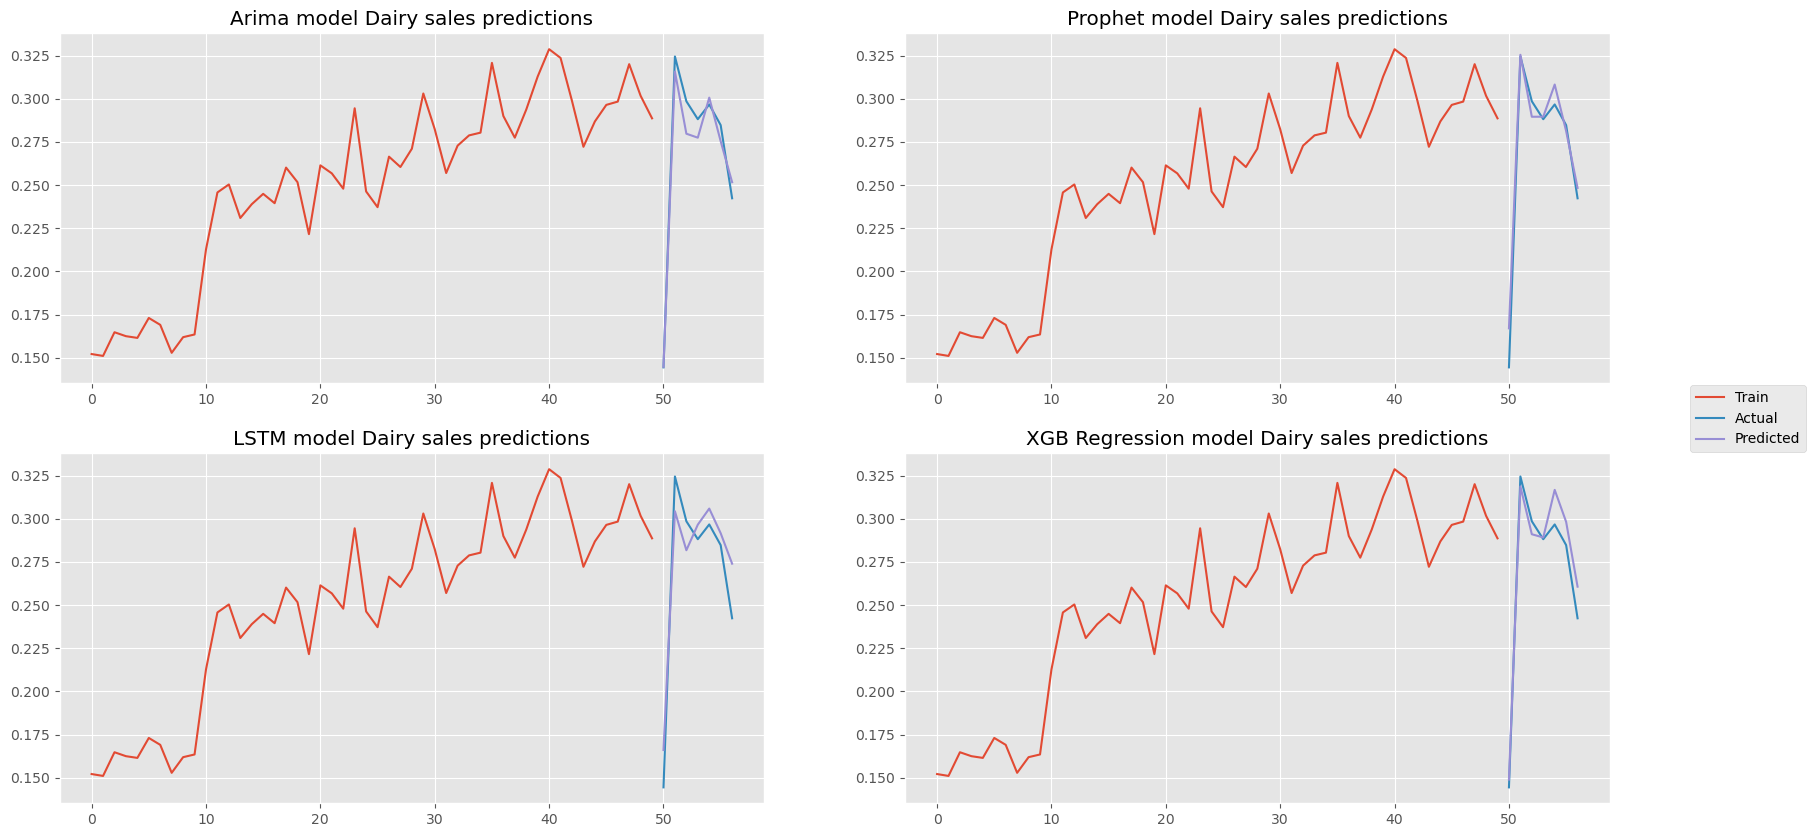

In [23]:
#Plots for predictions
fig, [(ax1,ax2),(ax3,ax4)] = plt.subplots(ncols=2,
                                          nrows = 2,
                                          figsize=(20, 10))

plot_predictions(arima_pred,'Arima model',y_name,ax1)
plot_predictions(prophet_pred,'Prophet model',y_name,ax2)
plot_predictions(lstm_pred, 'LSTM model',y_name,ax3)
plot_predictions(xg_pred, 'XGB Regression model',y_name,ax4)

fig.legend(['Train','Actual','Predicted'], loc = 'center right')
plt.show()

The Prophet model gives the best results.